In [193]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import numpy.polynomial.polynomial as poly

import itertools
import sqlite3

In [5]:
db = sqlite3.connect('results.sqlite3')

In [222]:
def fetch_run(name_or_id):
    if type(name_or_id) is str:
        runs = db.execute('SELECT run_id FROM runs WHERE name LIKE ?', (run_name,)).fetchall()
        if len(runs) > 1:
            raise ValueError('Ambiguous run name {} matches run ids {}'.format(run_name, runs))
    
        ((run_id,),), run_name = runs, name_or_id
    else:
        run_id, (run_name,) = name_or_id, db.execute('SELECT name FROM runs WHERE run_id == ?', (name_or_id,)).fetchone()
    
    data = db.execute('''
        SELECT channel, duty_cycle, voltage, voltage_stdev FROM measurements
        WHERE run_id == ?
        ORDER BY channel ASC, duty_cycle ASC;
        ''', (run_id,)).fetchall()
    
    _ch, cal_duty, *cal = data[0]
    assert cal_duty == 0
    grouped = {ch: [(duty, volt, stdev) for _ch, duty, volt, stdev in data]
               for ch, data in itertools.groupby(data, lambda elem: elem[0]) if ch != -1}
    return (run_id, run_name), grouped, cal

In [243]:
def plot_run(name_or_id):
    (run_id, run_name), data, cal = fetch_run(name_or_id)
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title('Run {} id {}'.format(run_name, run_id))
    ax.set_xscale('log')
    ax.set_yscale('log')

    min_x = 1e9
    max_y = 0
    cal_volt, cal_stdev = cal
    for ch in data:
        ch_data = data[ch]
        duty, volt, stdev = zip(*ch_data)
        vref = volt[0] - cal_volt
        volt = (np.array(volt) - cal_volt) / vref
        stdev = np.array(stdev) / vref
        max_y = max(max(volt), max_y)
        min_x = min(min(duty), min_x)
        ax.errorbar(duty, volt, yerr=stdev)
    
    # reuse latest duty cycles here
    ax.set_xticks(duty)
    ax.set_xticklabels([str(i) for i in range(len(duty))])
    ax.set_xlabel('bit index')
    ax.set_yticks([2**i for i in range(len(duty))])
    ax.set_yticklabels([str(2**i) for i in range(len(duty))])
    
    ax.set_xlim([min_x*0.9, 1.1])
    ax.set_ylim([0, max_y*1.1])

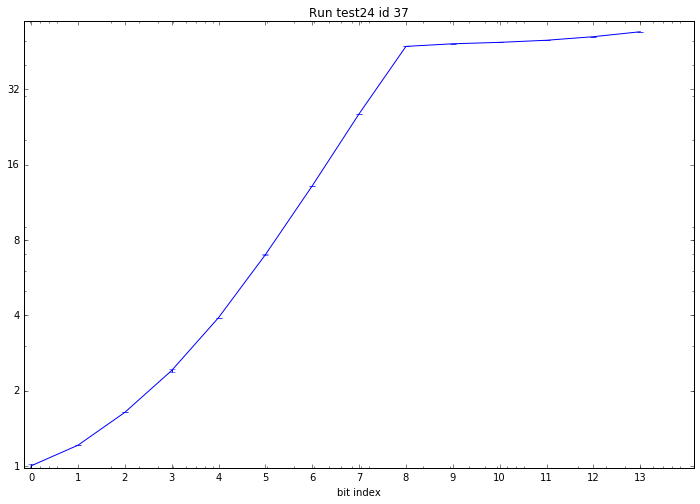

In [245]:
plot_run(37)